In [8]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *
from models import *

import pandas as pd
import tensorflow as tf
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

In [2]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")

In [3]:
CLUSTER_WITH = 'CashIn'

clustering_df = pd.DataFrame(dtype='float64')
feature_sets = []
atmIds = df['AtmId'].value_counts()[:20].index


for atmId in atmIds:
    atm_df = get_atm(df, atmId)
    atm_df = atm_df[:-135]
    atm_df = clean_data(atm_df, drop_zeros=True)
    
    for target in ['CashIn', 'CashOut']:
        atm_df[target] = np.log(atm_df[target] + 1e-6)

    day_of_the_week_index = get_day_of_the_week_index(atm_df.index)

    for i in range(7):
        clustering_df.loc[atmId, i] = atm_df.loc[day_of_the_week_index[day_of_the_week_index == i].index].mean()[CLUSTER_WITH]

    atm_df['AtmId'] = atmId
    feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])
    feature_sets.append(feature_set)

all_atms_feature_set = pd.concat(feature_sets, axis=0)

In [4]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(softmax(np.log(clustering_df.to_numpy()), axis=1))

d = {atmId:label for atmId, label in zip(atmIds, kmeans.labels_)}

all_atms_feature_set['ClusterId'] = all_atms_feature_set['AtmId'].map(d)
all_atms_feature_set.sort_index(inplace = True)
all_atms_feature_set

,CashIn,CashOut,AtmId,CashIn_average_7,CashIn_std_7,CashIn_average_14,CashIn_std_14,CashIn_average_30,CashIn_std_30,CashOut_average_7,...,ramazan_in_7_days,is_kurban,kurban_in_7_days,is_cocuk_bayrami,is_isci_bayrami,is_spor_bayrami,is_zafer_bayrami,is_cumhuriyet_bayrami,Special_Dates_Index,ClusterId
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-02-10,10.920890,10.504519,26637,10.822261,0.488059,10.766160,0.648204,10.744681,0.666070,10.767122,...,0,0,0,0,0,0,0,0,0,2
2016-02-10,9.068777,8.653471,33817,8.890898,0.370771,8.825474,0.314598,8.785353,0.401919,7.714785,...,0,0,0,0,0,0,0,0,0,0
2016-02-10,9.615805,10.892099,33821,10.043585,0.360265,9.724900,0.714795,9.884044,0.541103,10.501516,...,0,0,0,0,0,0,0,0,0,0
2016-02-10,8.738735,8.616133,32785,9.201520,0.653135,8.935890,0.697281,8.708739,0.824113,8.544139,...,0,0,0,0,0,0,0,0,0,4
2016-02-10,10.123025,10.858229,33793,10.098833,0.527358,10.197170,0.565005,10.251846,0.510294,10.362870,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-22,10.893586,10.647803,33800,9.392382,1.487854,10.088157,1.263981,10.459964,1.021926,8.690827,...,0,0,0,0,0,0,0,0,0,2
2020-01-22,10.586332,10.647565,33821,10.885208,0.226965,10.883184,0.256550,10.767129,0.289847,11.027071,...,0,0,0,0,0,0,0,0,0,0
2020-01-22,11.289032,11.375157,27664,11.493237,0.472146,11.322507,0.694794,11.321332,0.583270,11.411186,...,0,0,0,0,0,0,0,0,0,2


In [20]:
categorical_features = ['Day_of_the_Week_Index', 'Day_of_the_Month_Index',
       'Week_of_the_Year_Index', 'Is_Weekday', 'Special_Dates_Index',
       'is_cocuk_bayrami', 'is_isci_bayrami', 'is_spor_bayrami',
       'is_zafer_bayrami', 'is_cumhuriyet_bayrami', 'ClusterId']
continuous_features   = ['CashIn_average_7', 'CashIn_std_7',
       'CashIn_average_14', 'CashIn_std_14', 'CashIn_average_30',
       'CashIn_std_30', 'CashOut_average_7', 'CashOut_std_7',
       'CashOut_average_14', 'CashOut_std_14', 'CashOut_average_30',
       'CashOut_std_30', 'CashIn_trend_7', 'CashOut_trend_7',
        'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', 'CashOut_t-36', 'CashOut_t-37', 'CashOut_t-38',
       'CashOut_t-39', 'CashOut_t-40']

all_features = []
all_features.extend(categorical_features)
all_features.extend(continuous_features)

X = all_atms_feature_set[all_features]
y = all_atms_feature_set['CashIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

train_pool = Pool(data = X_train, label = y_train, cat_features=categorical_features)

In [21]:
cb = CatBoostRegressor()
cb.fit(train_pool)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.067466
0:	learn: 0.8972329	total: 74.9ms	remaining: 1m 14s
1:	learn: 0.8690842	total: 141ms	remaining: 1m 10s
2:	learn: 0.8430846	total: 200ms	remaining: 1m 6s
3:	learn: 0.8201641	total: 263ms	remaining: 1m 5s
4:	learn: 0.7989195	total: 322ms	remaining: 1m 4s
5:	learn: 0.7793839	total: 384ms	remaining: 1m 3s
6:	learn: 0.7624004	total: 440ms	remaining: 1m 2s
7:	learn: 0.7468447	total: 498ms	remaining: 1m 1s
8:	learn: 0.7324731	total: 564ms	remaining: 1m 2s
9:	learn: 0.7202659	total: 621ms	remaining: 1m 1s
10:	learn: 0.7077925	total: 683ms	remaining: 1m 1s
11:	learn: 0.6966376	total: 747ms	remaining: 1m 1s
12:	learn: 0.6868338	total: 810ms	remaining: 1m 1s
13:	learn: 0.6777395	total: 871ms	remaining: 1m 1s
14:	learn: 0.6697689	total: 934ms	remaining: 1m 1s
15:	learn: 0.6622772	total: 1s	remaining: 1m 1s
16:	learn: 0.6548938	total: 1.06s	remaining: 1m 1s
17:	learn: 0.6477653	total: 1.13s	remaining: 1m 1s
18:	learn: 0.6421186	total: 1.19s	remaining: 1m 1s
19:	learn: 

In [22]:
feature_importance = cb.get_feature_importance(train_pool)

In [42]:
feature_importance.reshape(1,-1).shape

(1, 79)

<AxesSubplot:xlabel='features'>

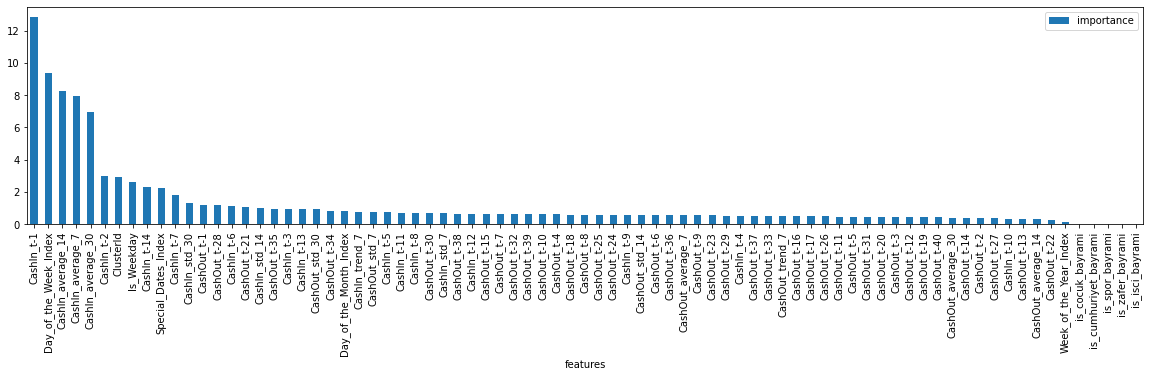

In [53]:
importance_df = pd.DataFrame({'features':all_features, 'importance':feature_importance})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df.plot.bar(x='features', y='importance',figsize=(20,4))


## Plotting

In [54]:
ATM_ID = 33793
atm_feature_set = all_atms_feature_set[all_atms_feature_set['AtmId'] == ATM_ID]
atm_feature_set

,CashIn,CashOut,AtmId,CashIn_average_7,CashIn_std_7,CashIn_average_14,CashIn_std_14,CashIn_average_30,CashIn_std_30,CashOut_average_7,...,ramazan_in_7_days,is_kurban,kurban_in_7_days,is_cocuk_bayrami,is_isci_bayrami,is_spor_bayrami,is_zafer_bayrami,is_cumhuriyet_bayrami,Special_Dates_Index,ClusterId
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-02-10,10.123025,10.858229,33793,10.098833,0.527358,10.197170,0.565005,10.251846,0.510294,10.362870,...,0,0,0,0,0,0,0,0,0,4
2016-02-11,10.585321,10.339805,33793,10.178370,0.472813,10.155326,0.545553,10.208057,0.458889,10.478028,...,0,0,0,0,0,0,0,0,0,4
2016-02-12,10.384678,10.595384,33793,10.308728,0.434432,10.187181,0.557439,10.230685,0.460241,10.499727,...,0,0,0,0,0,0,0,0,0,4
2016-02-13,10.730947,10.565144,33793,10.372486,0.402603,10.200833,0.559942,10.248592,0.455240,10.490585,...,0,0,0,0,0,0,0,0,0,4
2016-02-14,10.255552,9.889389,33793,10.475786,0.385870,10.224842,0.575879,10.272174,0.461458,10.490954,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-18,10.547970,10.901543,33793,10.510132,0.563365,10.518589,0.466491,10.597646,0.442682,10.732598,...,0,0,0,0,0,0,0,0,0,4
2020-01-19,10.160453,9.423838,33793,10.554516,0.550374,10.526167,0.466010,10.594889,0.442727,10.758224,...,0,0,0,0,0,0,0,0,0,4
2020-01-20,10.928991,10.863987,33793,10.662074,0.309905,10.549150,0.436495,10.567205,0.443072,10.658110,...,0,0,0,0,0,0,0,0,0,4


In [55]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [56]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_actual = pd.Series(np.exp(y_actual), index=y_actual.index)
    y_pred = pd.Series(np.exp(model.predict(X).reshape(-1)), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)
    print(weekly_errors.mean())

In [60]:
draw_model_error(cb, atm_feature_set[all_features], atm_feature_set['CashIn'], split_from=X_train.index[-1])

33.02796047249301
